# VAE Image generation

Cassandra Maldonado

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Parameters
latent_dim = 2
input_shape = (200, 200, 3)

In [16]:
# Defining the encoder
encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [17]:
# Sampling layer, this layer will sample from the learned latent space using the mean and log variance from the encoder.
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

In [18]:
# Building the encoder model, it will take the input image and output the mean and log variance of the latent space and the sampled latent vector.
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 100, 100,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 50, 50,    │     18,496 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 25, 25,    │     73,856 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 13, 13,    │    295,168 │ conv2d_10[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 43264)     │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │    692,240 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,080,724 (4.12 MB)

 Trainable params: 1,080,724 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Defining the decoder, which will take the sampled latent vector and reconstruct the image.
# The decoder will reverse the operations of the encoder and it will take the latent vector and upsample it back to the original image size.
# After 4 Conv2D layers with strides=2, the 200x200 image is reduced to 200/(2^4) = 12.5
# We'll use 13x13 as the starting point for the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(13 * 13 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((13, 13, 256))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # 26×26
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)   # 52×52
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)   # 104×104
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)   # 208×208
# Resize to exact 200×200 shape
x = layers.Cropping2D(cropping=((4, 4), (4, 4)))(x)  # 200×200
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)       # 200×200×3

In [21]:
# Building the decoder model, it will take the latent vector and output the reconstructed image.
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43264)          │       129,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 26, 26, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 52, 52, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 104, 104, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 208, 208, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_1 (Cropping2D)       │ (None, 200, 200, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 200, 200, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,147 (1.99 MB)

 Trainable params: 522,147 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get encoder outputs
            z_mean, z_log_var, z = self.encoder(data)
            
            # Decode the latent vector
            reconstruction = self.decoder(z)
            
            # Check shapes for debugging
            input_shape = tf.shape(data)
            output_shape = tf.shape(reconstruction)
            
            # Compute reconstruction loss (ensuring shapes match)
            flattened_inputs = tf.reshape(data, [tf.shape(data)[0], -1])
            flattened_outputs = tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])
            
            # Use tf.square() directly instead of mean_squared_error function
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(flattened_inputs - flattened_outputs),
                    axis=1
                )
            )
            
            # Compute KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            
            # Calculate total loss
            total_loss = reconstruction_loss + kl_loss
        
        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Create the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

### 1. Train VAE. Fit the VAE model using one of the 2 pictures, call it pic_1.

### Trim the picture to fit the input 200-by-200 dimensions using.

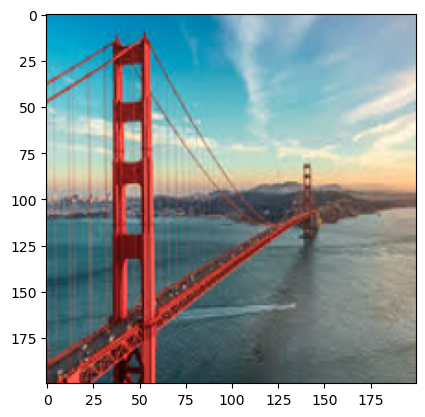

In [36]:
from PIL import Image

pic_1 = Image.open("pic_1.jpeg").convert("RGB")

pic_1 = pic_1.resize((220, 202))
pic_1 = np.array(pic_1)

pic_1 = np.expand_dims(pic_1, 0).astype("float32") / 255
pic_1 = pic_1[:,-201:-1, 0:200]

plt.imshow(pic_1[0])

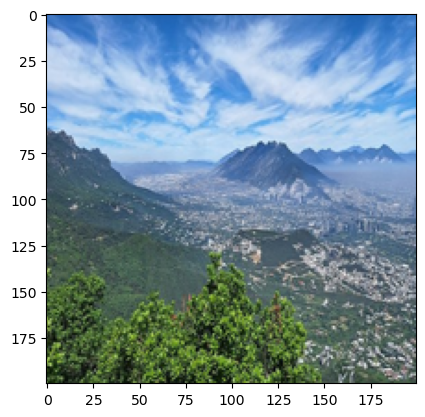

In [38]:
pic_2 = Image.open("pic_2.jpeg").convert("RGB")

pic_2 = pic_2.resize((220, 202))
pic_2 = np.array(pic_2)

pic_2 = np.expand_dims(pic_2, 0).astype("float32") / 255
pic_2 = pic_2[:,-201:-1, 0:200]

plt.imshow(pic_2[0])

In [39]:
# Function to show images
def show_plot(images):
    plt.figure(figsize=(10, 5))
    for i in range(min(images.shape[0], 5)):  # Show up to 5 images
        plt.subplot(1, min(images.shape[0], 5), i + 1)
        img = np.clip(images[i], 0, 1)  # Ensure values are in [0,1]
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [40]:
# 1. Train VAE on pic_1
print("Training VAE on pic_1...")
vae.fit(pic_1, epochs=50, batch_size=1)

Training VAE on pic_1...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - kl_loss: 0.0136 - loss: 21742.6934 - reconstruction_loss: 21742.6797
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 0.0203 - loss: 23903.6367 - reconstruction_loss: 23903.6172
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 0.0337 - loss: 18530.2031 - reconstruction_loss: 18530.1699
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 0.0475 - loss: 15475.0059 - reconstruction_loss: 15474.9580
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 0.0828 - loss: 13070.5381 - reconstruction_loss: 13070.4551
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 0.1580 - loss: 12059.8340 - reconstruction_loss: 12059.6758
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 0.3316 - loss: 9391.0918 - reconstruction_loss: 9390.7598
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 0.5458 - loss: 8341.7031 - reconstruction_loss: 8341.1572
Epoch 9/50
1/1 ━━━━

In [41]:
# 2. Sample the latent space
print("\nExplaining the Sampling function:")
print("""
The Sampling function is a crucial component of VAEs. It implements the 
"reparameterization trick" which allows backpropagation through randomness.

Given z_mean and z_log_var from the encoder:
1. First, it gets the batch size and latent dimension
2. Then it generates random noise (epsilon) from a normal distribution
3. Finally, it applies the formula: z = z_mean + exp(0.5 * z_log_var) * epsilon

This creates a sample from the learned distribution in the latent space
while keeping the operation differentiable for training.
""")


Explaining the Sampling function:

The Sampling function is a crucial component of VAEs. It implements the 
"reparameterization trick" which allows backpropagation through randomness.

Given z_mean and z_log_var from the encoder:
1. First, it gets the batch size and latent dimension
2. Then it generates random noise (epsilon) from a normal distribution
3. Finally, it applies the formula: z = z_mean + exp(0.5 * z_log_var) * epsilon

This creates a sample from the learned distribution in the latent space
while keeping the operation differentiable for training.




Generating images from pic_1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
z_mean: [[ -6.6062284 -12.3164625]]
z_log_var: [[-10.374746  -8.394298]]
encoded_imgs shape: (1, 2)

Original pic_1:


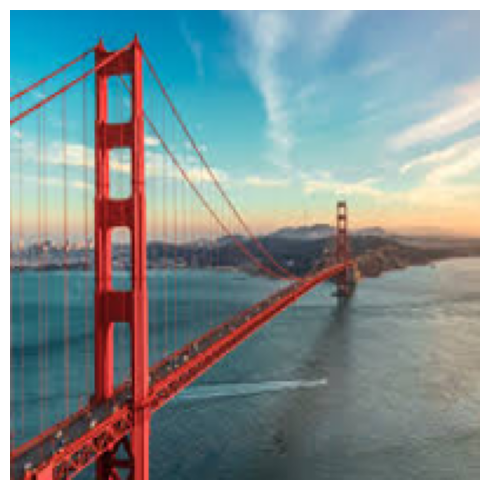

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Decoded image shape: (1, 200, 200, 3)

Reconstructed pic_1:


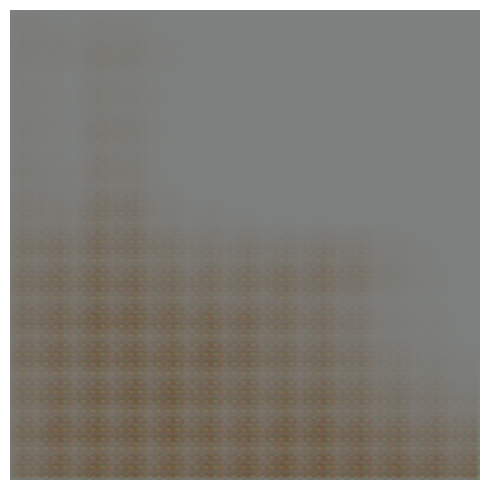


Generating multiple variations:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Run 1 - Generated variation with epsilon = [[-2.61254901  0.95036968]]


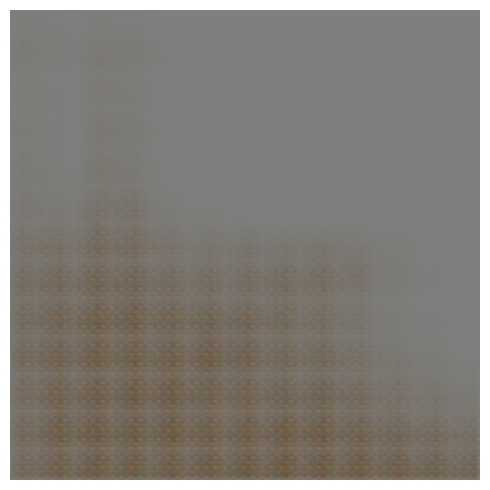

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Run 2 - Generated variation with epsilon = [[ 0.81644508 -1.523876  ]]


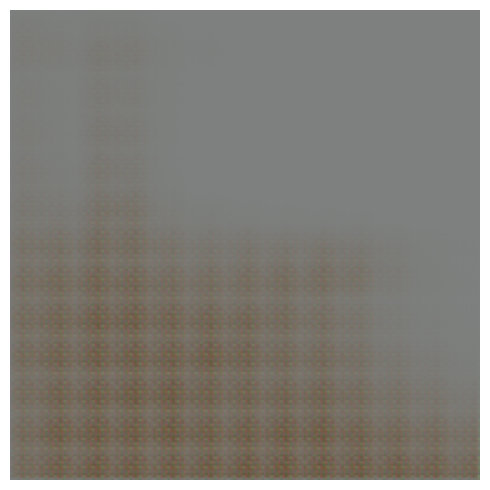

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Run 3 - Generated variation with epsilon = [[-0.42804606 -0.74240684]]


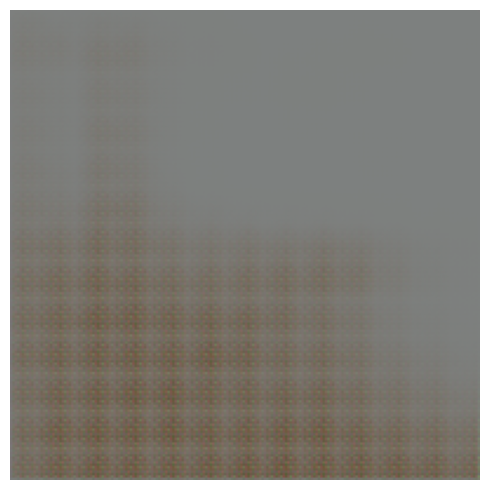

In [42]:
# 3. Generate Images
print("\nGenerating images from pic_1...")
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_1)

print("z_mean:", z_mean)
print("z_log_var:", z_log_var)
print("encoded_imgs shape:", encoded_imgs.shape)

print("\nOriginal pic_1:")
show_plot(pic_1)

decoded_imgs = decoder.predict(encoded_imgs)
print("Decoded image shape:", decoded_imgs.shape)
print("\nReconstructed pic_1:")
show_plot(decoded_imgs)

# Run multiple times to show variation
print("\nGenerating multiple variations:")
for i in range(3):
    # Sample points from the latent space
    epsilon = np.random.normal(size=(1, latent_dim))
    z_sample = z_mean + np.exp(0.5 * z_log_var) * epsilon
    
    # Decode the point to get a generated image
    x_decoded = decoder.predict(z_sample)
    print(f"Run {i+1} - Generated variation with epsilon =", epsilon)
    show_plot(x_decoded)


Testing with pic_2 (not used during training):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Original pic_2:


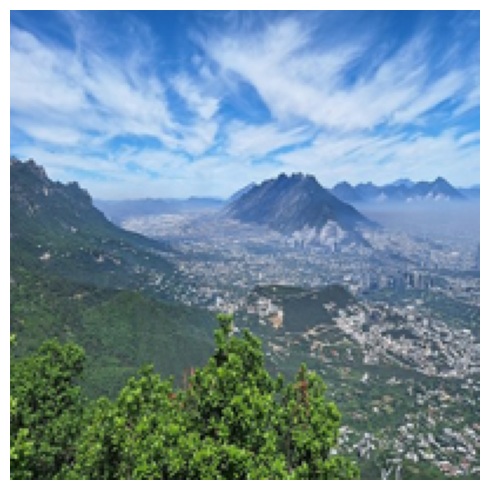

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Reconstructed pic_2:


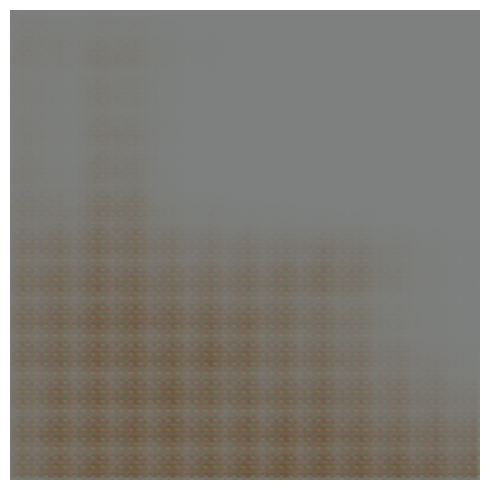


Explanation of pic_2 results:

When testing with pic_2 (which wasn't used during training), we can observe that:
- The VAE encoder maps pic_2 to a point in the latent space
- The decoder then reconstructs an image from this latent representation
- Since the decoder was only trained to reconstruct pic_1, the output looks more like pic_1 than pic_2
- This happens because the VAE learns to map the entire latent space to variations of what it has seen during training

This demonstrates a key limitation of training on limited data. To generate diverse 
images, VAEs need to be trained on diverse datasets.



In [43]:
# 4. Test with pic_2
print("\nTesting with pic_2 (not used during training):")
z_mean_2, z_log_var_2, encoded_imgs_2 = encoder.predict(pic_2)

print("Original pic_2:")
show_plot(pic_2)

decoded_imgs_2 = decoder.predict(encoded_imgs_2)
print("Reconstructed pic_2:")
show_plot(decoded_imgs_2)

print("\nExplanation of pic_2 results:")
print("""
When testing with pic_2 (which wasn't used during training), we can observe that:
- The VAE encoder maps pic_2 to a point in the latent space
- The decoder then reconstructs an image from this latent representation
- Since the decoder was only trained to reconstruct pic_1, the output looks more like pic_1 than pic_2
- This happens because the VAE learns to map the entire latent space to variations of what it has seen during training

This demonstrates a key limitation of training on limited data. To generate diverse 
images, VAEs need to be trained on diverse datasets.
""")